In [92]:
import sympy as sp
sp.init_printing()
import IPython.display as disp
%matplotlib ipympl
import matplotlib.pyplot as plt
#plt.rcParams['text.usetex'] = True
import numpy as np

In [93]:
# !!! Indicates a hypothesis (should be studied and considered)

# !!! Mode selection
mode_values = "real" # real or complex values

Wavenumber variables

In [94]:
# Physical wavenumber
k = sp.Symbol('k',
              #real=True, # !!!
              #positive=True, # !!!
              )

Override inconvenient SymPy behaviour via class surgery

In [95]:
from sympy.vector import CoordSys3D

from collections.abc import Callable

from sympy.core import S, Dummy, Lambda
from sympy.core.symbol import Str
from sympy.core.symbol import symbols
from sympy.matrices.immutable import ImmutableDenseMatrix as Matrix
from sympy.matrices.matrixbase import MatrixBase
from sympy.vector.scalar import BaseScalar
from sympy.core.containers import Tuple
from sympy.matrices.dense import eye
from sympy.matrices.immutable import ImmutableDenseMatrix
from sympy.vector.coordsysrect import _check_strings
from sympy.vector.vector import BaseVector



# Gives an ambiguous name to coordinates
# x,sys is now x in LaTeX
# Convenient for LaTex printing when working with a unique system
# Otherwise stupid and dangerous
class CoordSys3DUnique(CoordSys3D):

    def __new__(cls, name, transformation=None, parent=None, location=None,
                rotation_matrix=None, vector_names=None, variable_names=None):
        """
        The orientation/location parameters are necessary if this system
        is being defined at a certain orientation or location wrt another.

        Parameters
        ==========

        name : str
            The name of the new CoordSys3D instance.

        transformation : Lambda, Tuple, str
            Transformation defined by transformation equations or chosen
            from predefined ones.

        location : Vector
            The position vector of the new system's origin wrt the parent
            instance.

        rotation_matrix : SymPy ImmutableMatrix
            The rotation matrix of the new coordinate system with respect
            to the parent. In other words, the output of
            new_system.rotation_matrix(parent).

        parent : CoordSys3D
            The coordinate system wrt which the orientation/location
            (or both) is being defined.

        vector_names, variable_names : iterable(optional)
            Iterables of 3 strings each, with custom names for base
            vectors and base scalars of the new system respectively.
            Used for simple str printing.

        """

        name = str(name)
        Vector = sp.vector.Vector
        Point = sp.vector.Point

        if not isinstance(name, str):
            raise TypeError("name should be a string")

        if transformation is not None:
            if (location is not None) or (rotation_matrix is not None):
                raise ValueError("specify either `transformation` or "
                                 "`location`/`rotation_matrix`")
            if isinstance(transformation, (Tuple, tuple, list)):
                if isinstance(transformation[0], MatrixBase):
                    rotation_matrix = transformation[0]
                    location = transformation[1]
                else:
                    transformation = Lambda(transformation[0],
                                            transformation[1])
            elif isinstance(transformation, Callable):
                x1, x2, x3 = symbols('x1 x2 x3', cls=Dummy)
                transformation = Lambda((x1, x2, x3),
                                        transformation(x1, x2, x3))
            elif isinstance(transformation, str):
                transformation = Str(transformation)
            elif isinstance(transformation, (Str, Lambda)):
                pass
            else:
                raise TypeError("transformation: "
                                "wrong type {}".format(type(transformation)))

        # If orientation information has been provided, store
        # the rotation matrix accordingly
        if rotation_matrix is None:
            rotation_matrix = ImmutableDenseMatrix(eye(3))
        else:
            if not isinstance(rotation_matrix, MatrixBase):
                raise TypeError("rotation_matrix should be an Immutable" +
                                "Matrix instance")
            rotation_matrix = rotation_matrix.as_immutable()

        # If location information is not given, adjust the default
        # location as Vector.zero
        if parent is not None:
            if not isinstance(parent, CoordSys3D):
                raise TypeError("parent should be a " +
                                "CoordSys3D/None")
            if location is None:
                location = Vector.zero
            else:
                if not isinstance(location, Vector):
                    raise TypeError("location should be a Vector")
                # Check that location does not contain base
                # scalars
                for x in location.free_symbols:
                    if isinstance(x, BaseScalar):
                        raise ValueError("location should not contain" +
                                         " BaseScalars")
            origin = parent.origin.locate_new(name + '.origin',
                                              location)
        else:
            location = Vector.zero
            origin = Point(name + '.origin')

        if transformation is None:
            transformation = Tuple(rotation_matrix, location)

        if isinstance(transformation, Tuple):
            lambda_transformation = CoordSys3D._compose_rotation_and_translation(
                transformation[0],
                transformation[1],
                parent
            )
            r, l = transformation
            l = l._projections
            lambda_lame = CoordSys3D._get_lame_coeff('cartesian')
            lambda_inverse = lambda x, y, z: r.inv()*Matrix(
                [x-l[0], y-l[1], z-l[2]])
        elif isinstance(transformation, Str):
            trname = transformation.name
            lambda_transformation = CoordSys3D._get_transformation_lambdas(trname)
            if parent is not None:
                if parent.lame_coefficients() != (S.One, S.One, S.One):
                    raise ValueError('Parent for pre-defined coordinate '
                                 'system should be Cartesian.')
            lambda_lame = CoordSys3D._get_lame_coeff(trname)
            lambda_inverse = CoordSys3D._set_inv_trans_equations(trname)
        elif isinstance(transformation, Lambda):
            if not CoordSys3D._check_orthogonality(transformation):
                raise ValueError("The transformation equation does not "
                                 "create orthogonal coordinate system")
            lambda_transformation = transformation
            lambda_lame = CoordSys3D._calculate_lame_coeff(lambda_transformation)
            lambda_inverse = None
        else:
            lambda_transformation = lambda x, y, z: transformation(x, y, z)
            lambda_lame = CoordSys3D._get_lame_coeff(transformation)
            lambda_inverse = None

        if variable_names is None:
            if isinstance(transformation, Lambda):
                variable_names = ["x1", "x2", "x3"]
            elif isinstance(transformation, Str):
                if transformation.name == 'spherical':
                    variable_names = ["r", "theta", "phi"]
                elif transformation.name == 'cylindrical':
                    variable_names = ["r", "theta", "z"]
                else:
                    variable_names = ["x", "y", "z"]
            else:
                variable_names = ["x", "y", "z"]
        if vector_names is None:
            vector_names = ["i", "j", "k"]

        # All systems that are defined as 'roots' are unequal, unless
        # they have the same name.
        # Systems defined at same orientation/position wrt the same
        # 'parent' are equal, irrespective of the name.
        # This is true even if the same orientation is provided via
        # different methods like Axis/Body/Space/Quaternion.
        # However, coincident systems may be seen as unequal if
        # positioned/oriented wrt different parents, even though
        # they may actually be 'coincident' wrt the root system.
        if parent is not None:
            obj = super().__new__(
                cls, Str(name), transformation, parent)
        else:
            obj = super().__new__(
                cls, Str(name), transformation)
        obj._name = name
        # Initialize the base vectors

        _check_strings('vector_names', vector_names)
        vector_names = list(vector_names)
        latex_vects = [(r'\mathbf{\hat{%s}_{%s}}' % (x, name)) for
                           x in vector_names]
        pretty_vects = ['%s_%s' % (x, name) for x in vector_names]

        obj._vector_names = vector_names

        v1 = BaseVector(0, obj, pretty_vects[0], latex_vects[0])
        v2 = BaseVector(1, obj, pretty_vects[1], latex_vects[1])
        v3 = BaseVector(2, obj, pretty_vects[2], latex_vects[2])

        obj._base_vectors = (v1, v2, v3)

        # Initialize the base scalars

        _check_strings('variable_names', vector_names)
        variable_names = list(variable_names)
        # !!! here
        latex_scalars = [(r"\mathbf{{%s}}" % (x)) for
                         x in variable_names]
        pretty_scalars = ['%s_%s' % (x, name) for x in variable_names]

        obj._variable_names = variable_names
        obj._vector_names = vector_names

        x1 = BaseScalar(0, obj, pretty_scalars[0], latex_scalars[0])
        x2 = BaseScalar(1, obj, pretty_scalars[1], latex_scalars[1])
        x3 = BaseScalar(2, obj, pretty_scalars[2], latex_scalars[2])

        obj._base_scalars = (x1, x2, x3)

        obj._transformation = transformation
        obj._transformation_lambda = lambda_transformation
        obj._lame_coefficients = lambda_lame(x1, x2, x3)
        obj._transformation_from_parent_lambda = lambda_inverse

        setattr(obj, variable_names[0], x1)
        setattr(obj, variable_names[1], x2)
        setattr(obj, variable_names[2], x3)

        setattr(obj, vector_names[0], v1)
        setattr(obj, vector_names[1], v2)
        setattr(obj, vector_names[2], v3)

        # Assign params
        obj._parent = parent
        if obj._parent is not None:
            obj._root = obj._parent._root
        else:
            obj._root = obj

        obj._parent_rotation_matrix = rotation_matrix
        obj._origin = origin

        # Return the instance
        return obj

Coordinate variables

In [96]:
sys = CoordSys3DUnique('sys', vector_names=['i', 'j', 'k'])
x, y, z = sys.x, sys.y, sys.z



Galerkine variational forms

In [97]:
from sympy.vector import gradient


def a_G(u, v, xa, xb, ya, yb, za, zb):
    
    # gradients
    grad_u = gradient(u)
    grad_v = gradient(v)
    
    return sp.integrate(grad_u & grad_v, (x, xa, xb), (y, ya, yb), (z, za, zb)) - (k**2 * sp.integrate(u * v, (x, xa, xb), (y, ya, yb), (z, za, zb)))


Grid sizes

In [98]:
h_ = dict()

for xi in [x, y, z]:
    h_[xi] = dict()
    
    for i in ["-", "+"]:
        h_[xi][i] = sp.Symbol(f'h_{sp.latex(xi)}^{i}')
        
        disp.display(h_[xi][i])

Grid points centered around origin

In [99]:
grid_ = dict()

for xi in [x, y, z]:
    grid_[xi] = dict()
    
    grid_[xi]["-"], grid_[xi]["0"], grid_[xi]["+"] = -h_[xi]["-"], sp.sympify(0), +h_[xi]["+"]
    
    disp.display(grid_[xi]["-"], grid_[xi]["0"], grid_[xi]["+"])

Point-wise linear shape functions for the three dimensions

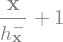

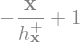

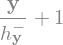

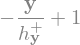

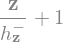

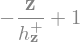

In [100]:
N_ = dict()

for xi in [x, y, z]:
    N_[xi] = dict()
    
    N_[xi]["-1"] = xi / h_[xi]["-"]
    N_[xi]["0-"] = (xi / h_[xi]["-"]) + 1
    N_[xi]["0+"] = (- xi / h_[xi]["+"]) + 1
    N_[xi]["+1"] = xi / h_[xi]["+"]
    
    disp.display(N_[xi]["-1"], N_[xi]["0-"], N_[xi]["0+"], N_[xi]["+1"])

Point-wise trilinear shape functions as products

In [101]:
from itertools import product


for (i, j, k) in product(["-1", "0-", "0+", "+1"], repeat=3):
    N_[f'{i}, {j}, {k}'] = N_[x][i] * N_[y][j] * N_[z][k]

Check that the sum of all functions is $1$